In [ ]:
#!/usr/bin/env python3
"""
Geometric Quantum Dot System Example

This script demonstrates how to define quantum dot systems using geometric positions
of dots and sensors, allowing users to specify physical layouts and automatically
compute capacitance matrices based on geometric considerations.

Key Features:
1. Geometric positioning: Define dots and sensors by their 2D or 3D positions
2. Automatic capacitance computation: Capacitance matrices are computed based on distances
3. Visual system layout: Plot the geometric arrangement of dots and sensors
4. Configurable parameters: Adjust coupling strength and distance decay parameters
5. Integration with existing simulator: Use the geometric system with the full ReadSpyn simulator

Implementation Details:
- Dot-dot capacitances follow C_ij = C0 for i=j, -α*C0*exp(-β*d_ij) for i≠j
- Dot-sensor capacitances follow C_ij = -α*C0*exp(-β*d_ij)
- Distances are computed using Euclidean norm
- The system integrates seamlessly with existing ReadSpyn components
"""

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any
import sys
import os

# extra
from readout_simulator.noise_models import CorrelatedNoise
import readout_simulator.helper_functions as hf
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  

# Add the src directory to the path
sys.path.append("../src/")

try:
    from readout_simulator import (
        GeometricQuantumDotSystem,
        RLC_sensor, 
        JAXReadoutSimulator,
        OU_noise, 
        OverFNoise
    )
    print("✓ Successfully imported ReadSpyn components")
except ImportError as e:
    print(f"✗ Failed to import ReadSpyn components: {e}")
    sys.exit(1)


✓ Successfully imported ReadSpyn components


In [2]:
# Set JAX random key for reproducibility
key = jax.random.PRNGKey(42)

# Example: Simple 2-dot, 2-sensor system
print("\n1. Creating a simple 2-dot, 2-sensor system...")

dot_positions = np.array([
    [0.0, 0.0],
    [100., 0.]     
])

sensor_positions = np.array([
    [0, 43.3],   
    [40.0, -43.3]    
])

# Create geometric system with different parameters
geo_system = GeometricQuantumDotSystem(
    dot_positions=dot_positions,
    sensor_positions=sensor_positions,
    C0=1e-15,      # Base capacitance: 1 fF
    alpha=0.8,     # Stronger coupling
    beta=0.005     # Longer range coupling
)


1. Creating a simple 2-dot, 2-sensor system...
Dot-sensor coupling strength (Δε/ε_w): [[-1.13710314 -1.01568878]
 [-1.12995948 -1.10089224]]


Created complex geometric system: GeometricQuantumDotSystem:
  Number of dots: 2
  Number of sensors: 2
  Dimensions: 2D
  Base capacitance (C0): 1.00e-15 F
  Coupling strength (α): 0.8
  Distance decay (β): 0.005
  Average dot-dot coupling: 7.43e-16 F
  Average dot-sensor coupling: 5.64e-16 F
  Max coupling strength: 1.137
  Min coupling strength: 1.016

Plotting complex system layout...


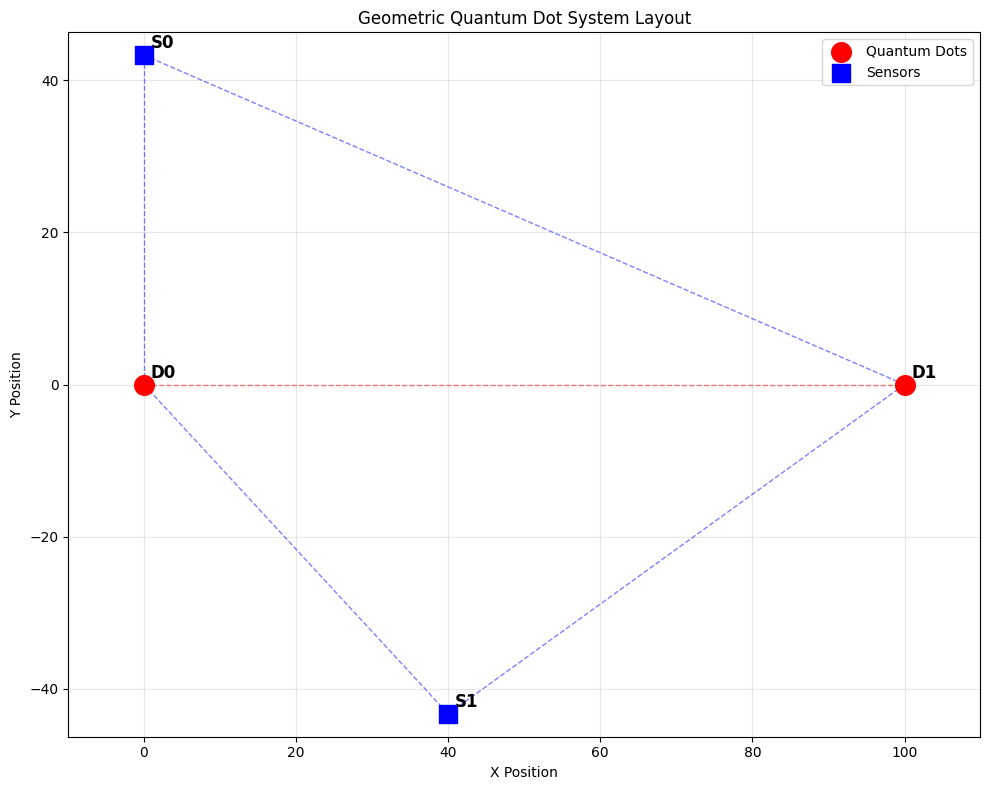


Complex system coupling information:
  Average dot-dot coupling: 7.43e-16 F
  Average dot-sensor coupling: 5.64e-16 F
  Max coupling strength: 1.137
  Min coupling strength: 1.016


In [3]:
print(f"Created complex geometric system: {geo_system}")

# Plot the complex system layout
print("\nPlotting complex system layout...")
geo_system.plot_system(show_capacitances=True, capacitance_threshold=0.005)

# Get coupling information for complex system
coupling_info_2 = geo_system.get_coupling_info()
print(f"\nComplex system coupling information:")
print(f"  Average dot-dot coupling: {coupling_info_2['avg_dot_dot_coupling']:.2e} F")
print(f"  Average dot-sensor coupling: {coupling_info_2['avg_dot_sensor_coupling']:.2e} F")
print(f"  Max coupling strength: {coupling_info_2['max_coupling']:.3f}")
print(f"  Min coupling strength: {coupling_info_2['min_coupling']:.3f}")

In [ ]:
# Integration with full simulator
print("\n\nIntegrating with full ReadSpyn simulator...")

# Use the first geometric system for simulation
dot_system = geo_system.dot_system

print(f"Using geometric system: {dot_system.num_dots} dots, {dot_system.num_sensors} sensors")

# Configure sensor parameters
params_resonator = {
    'Lc': 800e-9,      # Inductance (H)
    'Cp': 0.5e-12,     # Parasitic capacitance (F)
    'RL': 40,          # Load resistance (Ω)
    'Rc': 100e6,       # Coupling resistance (Ω)
    'Z0': 50           # Characteristic impedance (Ω)
}

params_coulomb_peak = {
    'g0': 1/50,        # Maximum conductance (S)
    'eps0': 0.5,       # Operating point (relative to eps_width)
    'eps_width': 1.0   # Energy width (eV)
}


params_coulomb_peak_2 = {
    'g0': 1/50,        # Maximum conductance (S)
    'eps0': 0.25,       # Operating point (relative to eps_width)
    'eps_width': 1.0   # Energy width (eV)
}


# Noise models
#    - circuit noise (independent, very small here)
c_noise = OU_noise(sigma=1.5e-10, gamma=1e4)
c_noise_2 = OU_noise(sigma=1.0e-10, gamma=1e4)

#    - base eps noise per sensor (we'll correlate these across sensors via CorrelatedNoise)
base_eps_noise = OU_noise(sigma=0.25e-1, gamma=1e2)   # gamma = 1/tc, tc = 1e-2 s here

sensor1 = RLC_sensor(params_resonator, params_coulomb_peak, c_noise)
sensor2 = RLC_sensor(params_resonator, params_coulomb_peak_2, c_noise_2)
sensors = [sensor1, sensor2]

print(f"Sensor 1 resonant frequency: {sensor1.f0/1e9:.2f} GHz")
print(f"Sensor 2 resonant frequency: {sensor2.f0/1e9:.2f} GHz")

correlation_matrix = jnp.array([
    [1.0, 0.7],
    [0.7, 1.0]
])
correlated_eps_noise = CorrelatedNoise(base_eps_noise, correlation_matrix)


# Create simulator
simulator = JAXReadoutSimulator(dot_system, sensors) #what happend here?

# Define charge states to simulate
charge_states = jnp.array([
    [1, 0],  # First dot occupied
    [0, 1]
])
    
results_dict = {}
# Define simulation parameters
t_end = 2e-6  # 1 μs absolute end time
dt = 2.e-9   # 0.5 ns time step
times = jnp.arange(0, t_end, dt)



Integrating with full ReadSpyn simulator...
Using geometric system: 2 dots, 2 sensors
[RLC_sensor] Initialized with:
  Lc = 8.000e-07 H
  Cp = 5.000e-13 F
  Self-capacitance = 0.000e+00 F
  Total capacitance = 5.000e-13 F
  RL = 40 Ω
  Rc = 1.000e+08 Ω
  Z0 = 50 Ω
  R0 = 5.000e+01 Ω
  g0 = 2.000e-02 S
  eps_w = 1.000e+00 eV
  Resonant frequency = 2.516e+08 Hz
  Resonant period = 3.974e-09 s
  Capacitance noise model: OU_noise
  Energy noise model: None
[RLC_sensor] Initialized with:
  Lc = 8.000e-07 H
  Cp = 5.000e-13 F
  Self-capacitance = 0.000e+00 F
  Total capacitance = 5.000e-13 F
  RL = 40 Ω
  Rc = 1.000e+08 Ω
  Z0 = 50 Ω
  R0 = 5.000e+01 Ω
  g0 = 2.000e-02 S
  eps_w = 1.000e+00 eV
  Resonant frequency = 2.516e+08 Hz
  Resonant period = 3.974e-09 s
  Capacitance noise model: OU_noise
  Energy noise model: None
Sensor 1 resonant frequency: 0.25 GHz
Sensor 2 resonant frequency: 0.25 GHz


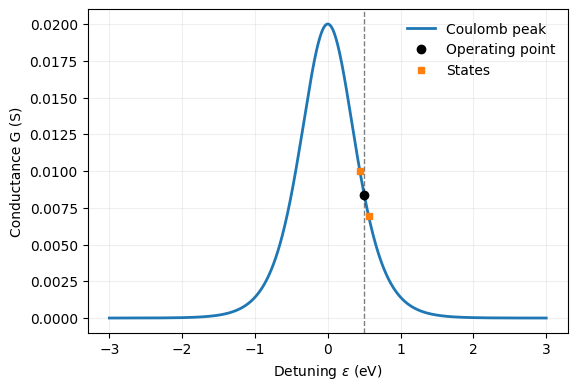

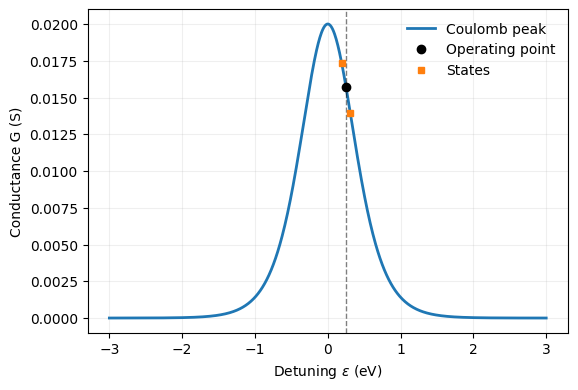

In [ ]:
t, eps_noise = hf.demo_ou_noise(T=2e-6, dt=0.5e-9, sigma=0.06, tau=2e-7)  # eV

ax, info = hf.plot_coulomb_peak_minimal(
    params_coulomb_peak,
    delta_eps=0.12,      # eV
    eps_noise= None #eps_noise  # array in eV
)
plt.show()

ax, info = hf.plot_coulomb_peak_minimal(
    params_coulomb_peak_2,
    delta_eps=0.12,      # eV
    eps_noise= None #eps_noise  # array in eV
)
plt.show()

In [6]:
n_realizations = 2000

snr = 3
params = {
        'eps0': 0.1, 
        'snr': snr,
        't_end': t_end
    }

key, subkey = jax.random.split(key)
simulator.precompute_noise(subkey, times, n_realizations, correlated_eps_noise)

key, subkey = jax.random.split(key)
results = simulator.run_simulation(charge_states, times, params, subkey)

Precomputing 2000 noise trajectory segments...
Using correlated noise for 2 sensors
Noise trajectory segments precomputed successfully.
Running simulation for 2 charge states with 2000 realizations...
Processing sensor 0...
Sensor 0: Average separation = 0.000010
Processing sensor 1...
Sensor 1: Average separation = 0.000002
Simulation completed successfully.


<AxesHostAxes: >

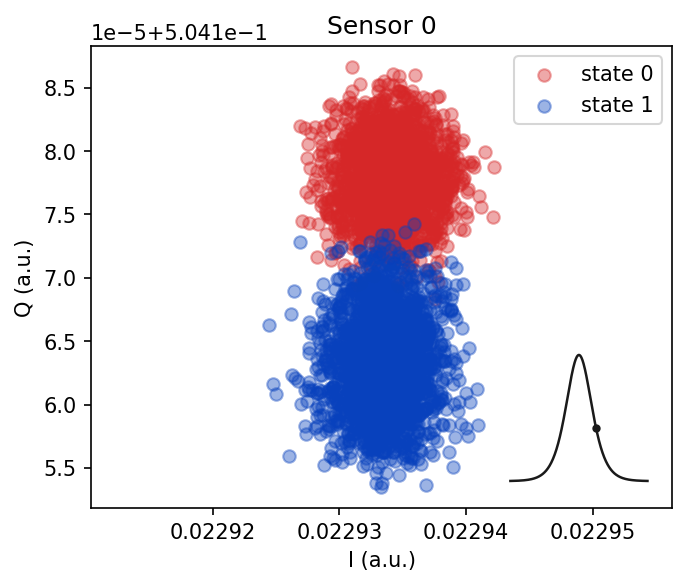

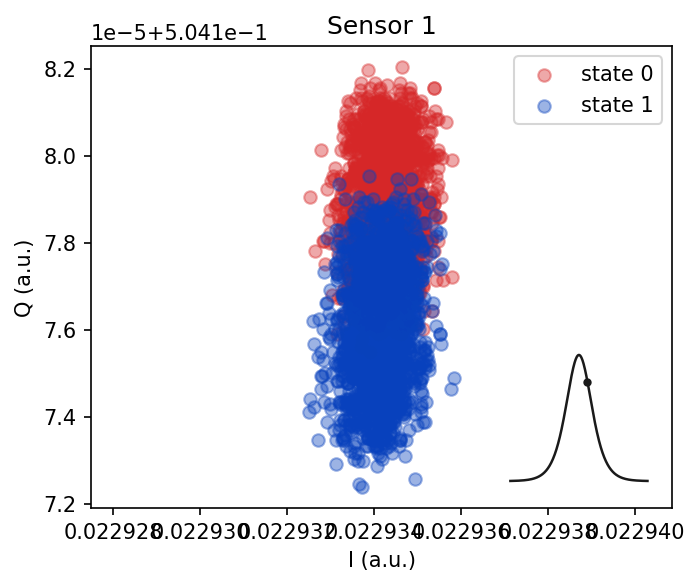

In [ ]:
 colors = ["#d62728",
          "#0841bd",  
          "#ff7f0e", 
          "#2ca02c"]  

plt.figure(dpi=150, figsize=(5,4))
for state_indx in range(len(charge_states)):
    I = results['sensor_results'][0]['I'][state_indx]
    Q = results['sensor_results'][0]['Q'][state_indx]
    
    I_integrated = np.cumsum(I, axis=-1) / np.arange(1, len(I[0]) + 1)
    Q_integrated = np.cumsum(Q, axis=-1) / np.arange(1, len(Q[0]) + 1)

    plt.scatter(I_integrated[:, -1], Q_integrated[:, -1],
                label=f'state {state_indx}', color=colors[state_indx], alpha=0.4)
    
plt.title('Sensor 0')
plt.xlabel('I (a.u.)')
plt.ylabel('Q (a.u.)')
plt.axis('equal')
plt.legend(loc='best')

# --- INSERT: Coulomb-peak inset (minimal) ---
ax_main = plt.gca()
ax_ins = inset_axes(ax_main, width="25%", height="30%", loc="lower right", borderpad=1.)
# operating point:
hf.plot_coulomb_peak_inset(params_coulomb_peak, ax=ax_ins, delta_eps=None, eps_noise=None)
# with state markers:
#hf.plot_coulomb_peak_inset(params_coulomb_peak, ax=ax_ins, delta_eps=0.12, eps_noise=None)


plt.figure(dpi=150, figsize=(5,4))
for state_indx in range(len(charge_states)):
    I = results['sensor_results'][1]['I'][state_indx]
    Q = results['sensor_results'][1]['Q'][state_indx]
    
    I_integrated = np.cumsum(I, axis=-1) / np.arange(1, len(I[0]) + 1)
    Q_integrated = np.cumsum(Q, axis=-1) / np.arange(1, len(Q[0]) + 1)

    plt.scatter(I_integrated[:, -1], Q_integrated[:, -1],
                label=f'state {state_indx}', color=colors[state_indx], alpha=0.4)

plt.title('Sensor 1')
plt.xlabel('I (a.u.)')
plt.ylabel('Q (a.u.)')
plt.axis('equal')
plt.legend(loc='best')

# --- INSERT: Coulomb-peak inset (minimal) ---
ax_main = plt.gca()
ax_ins = inset_axes(ax_main, width="25%", height="30%", loc="lower right", borderpad=1.)
# operating point:
hf.plot_coulomb_peak_inset(params_coulomb_peak_2, ax=ax_ins, delta_eps=None, eps_noise=None)
# with state markers:
#hf.plot_coulomb_peak_inset(params_coulomb_peak, ax=ax_ins, delta_eps=0.12, eps_noise=None)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
C:\Users\rouvenkoch\AppData\Local\Temp\ipykernel_65516\2131797734.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


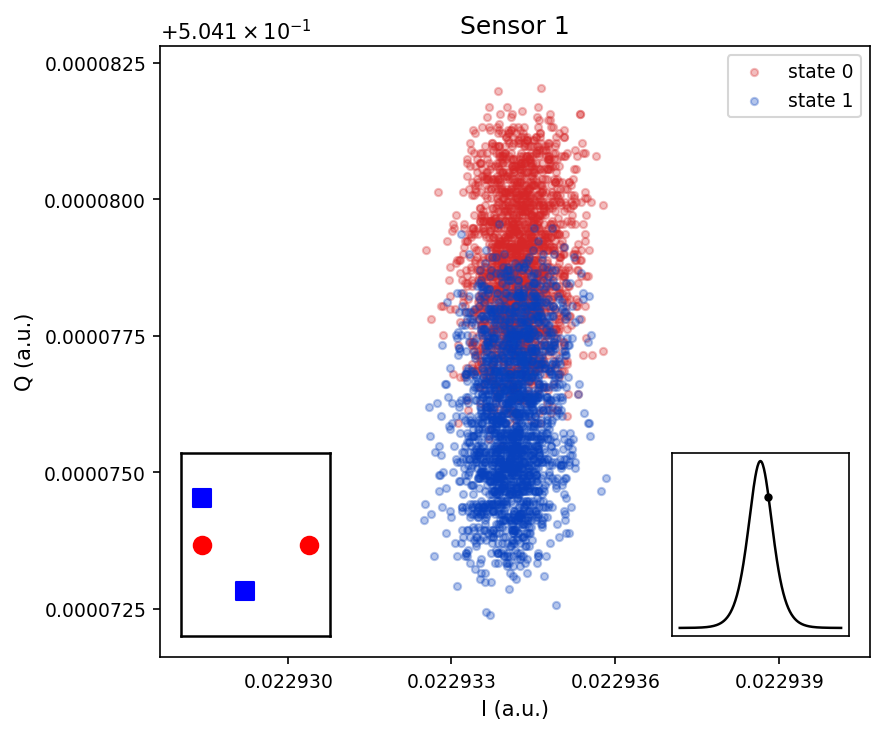

In [ ]:
plt.figure(dpi=150, figsize=(6,5))

xs, ys = [], []  # collect for autoscale with padding
for state_indx in range(len(charge_states)):
    I = results['sensor_results'][1]['I'][state_indx]
    Q = results['sensor_results'][1]['Q'][state_indx]
    I_integrated = np.cumsum(I, axis=-1) / np.arange(1, len(I[0]) + 1)
    Q_integrated = np.cumsum(Q, axis=-1) / np.arange(1, len(Q[0]) + 1)

    x = I_integrated[:, -1]
    y = Q_integrated[:, -1]
    xs.append(x); ys.append(y)

    plt.scatter(x, y, s=12, label=f'state {state_indx}', color=colors[state_indx], alpha=0.3)

plt.title('Sensor 1', pad=6)
plt.xlabel('I (a.u.)')
plt.ylabel('Q (a.u.)')
plt.axis('equal')
plt.legend(loc='best', frameon=True, fontsize=9)

ax = plt.gca()

# ---- Pretty ticks (no scientific offset, ~5 ticks, rounded) ----
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='plain', axis='both')           # turn off scientific notation & offsets
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))          # ~5 ticks
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=9)

# optional: pad limits a bit around data
X = np.concatenate(xs); Y = np.concatenate(ys)
xr = X.max() - X.min(); yr = Y.max() - Y.min()
pad_x = 0.08 * (xr if xr > 0 else (abs(X.mean()) + 1e-12))
pad_y = 0.08 * (yr if yr > 0 else (abs(Y.mean()) + 1e-12))
ax.set_xlim(X.min() - pad_x, X.max() + pad_x)
ax.set_ylim(Y.min() - pad_y, Y.max() + pad_y)

ax_main = plt.gca()

# --- Coulomb-peak inset (minimal, no labels) ---
ax_ins = inset_axes(ax, width="25%", height="30%", loc="lower right", borderpad=1.0)
hf.plot_minimal_coulomb_peak_inset(ax_ins, params_coulomb_peak_2)

# --- Insert 2: bottom left (qubit array layout) ---
ax_ins2 = inset_axes(ax_main, width="21%", height="30%", 
                     loc="lower left", borderpad=1.0)
hf.plot_qubit_array_insert(dot_positions, sensor_positions, ax=ax_ins2)

plt.tight_layout()
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
C:\Users\rouvenkoch\AppData\Local\Temp\ipykernel_65516\1602825946.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


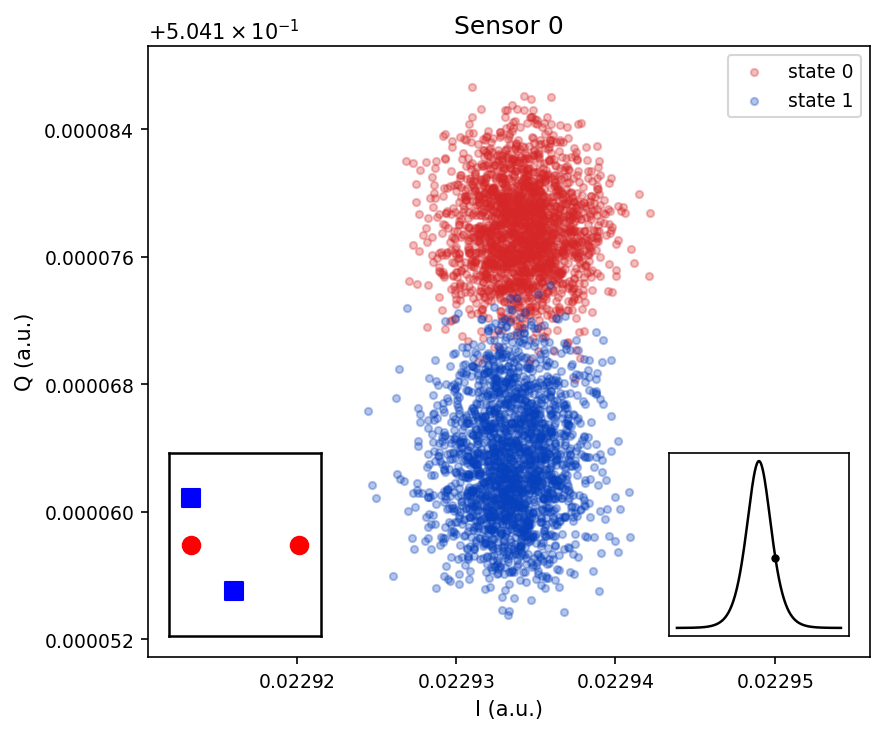

In [ ]:
plt.figure(dpi=150, figsize=(6,5))

xs, ys = [], []  # collect for autoscale with padding
for state_indx in range(len(charge_states)):
    I = results['sensor_results'][0]['I'][state_indx]
    Q = results['sensor_results'][0]['Q'][state_indx]
    I_integrated = np.cumsum(I, axis=-1) / np.arange(1, len(I[0]) + 1)
    Q_integrated = np.cumsum(Q, axis=-1) / np.arange(1, len(Q[0]) + 1)

    x = I_integrated[:, -1]
    y = Q_integrated[:, -1]
    xs.append(x); ys.append(y)

    plt.scatter(x, y, s=12, label=f'state {state_indx}', color=colors[state_indx], alpha=0.3)

plt.title('Sensor 0', pad=6)
plt.xlabel('I (a.u.)')
plt.ylabel('Q (a.u.)')
plt.axis('equal')
plt.legend(loc='best', frameon=True, fontsize=9)

ax = plt.gca()

# ---- Pretty ticks (no scientific offset, ~5 ticks, rounded) ----
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='plain', axis='both')           # turn off scientific notation & offsets
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))          # ~5 ticks
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=9)

# optional: pad limits a bit around data
X = np.concatenate(xs); Y = np.concatenate(ys)
xr = X.max() - X.min(); yr = Y.max() - Y.min()
pad_x = 0.08 * (xr if xr > 0 else (abs(X.mean()) + 1e-12))
pad_y = 0.08 * (yr if yr > 0 else (abs(Y.mean()) + 1e-12))
ax.set_xlim(X.min() - pad_x, X.max() + pad_x)
ax.set_ylim(Y.min() - pad_y, Y.max() + pad_y)

ax_main = plt.gca()

# --- Coulomb-peak inset (minimal, no labels) ---
ax_ins = inset_axes(ax, width="25%", height="30%", loc="lower right", borderpad=1.0)
hf.plot_minimal_coulomb_peak_inset(ax_ins, params_coulomb_peak)

# --- Insert 2: bottom left (qubit array layout) ---
ax_ins2 = inset_axes(ax_main, width="21%", height="30%", 
                     loc="lower left", borderpad=1.0)
hf.plot_qubit_array_insert(dot_positions, sensor_positions, ax=ax_ins2)

plt.tight_layout()
plt.show()


## ML part

In [38]:
# create ML dataset 2 sensor 2 states
I_integrated_all_s0 = []
Q_integrated_all_s0 = []

I_integrated_all_s1 = []
Q_integrated_all_s1 = []

labels_all = [] # 0 for state 1, 1 for state 2

for state_indx in range(len(charge_states)):
    I = results['sensor_results'][0]['I'][state_indx]
    I_integrated_all_s0.append(I_integrated)
    I_integrated_s0 = np.cumsum(I, axis=-1)/np.arange(1, len(I[0])+1)
            
    Q = results['sensor_results'][0]['Q'][state_indx]
    Q_integrated_all_s0.append(Q_integrated)
    Q_integrated_s0 = np.cumsum(Q, axis=-1)/np.arange(1, len(Q[0])+1)
    
for state_indx in range(len(charge_states)):
    I = results['sensor_results'][1]['I'][state_indx]
    I_integrated_all_s1.append(I_integrated)
    I_integrated_s = np.cumsum(I, axis=-1)/np.arange(1, len(I[0])+1)
            
    Q = results['sensor_results'][1]['Q'][state_indx]
    Q_integrated_all_s1.append(Q_integrated)
    Q_integrated_s1 = np.cumsum(Q, axis=-1)/np.arange(1, len(Q[0])+1)
    
    labels_all.append(np.full(I_integrated.shape[0], state_indx))


I_integrated_all_s0 = np.vstack(I_integrated_all_s0)  # shape (n_samples, n_time_steps)
Q_integrated_all_s0 = np.vstack(Q_integrated_all_s0)  # shape (n_samples, n_time_steps)
labels_all = np.concatenate(labels_all)  # shape (n_samples,)
print(f"Final dataset shapes: I {I_integrated_all_s0.shape}, Q {Q_integrated_all_s0.shape}, labels {labels_all.shape}")

I_integrated_all_s1 = np.vstack(I_integrated_all_s1)  # shape (n_samples, n_time_steps)
Q_integrated_all_s1 = np.vstack(Q_integrated_all_s1)  # shape (n_samples, n_time_steps)
print(f"Final dataset shapes: I {I_integrated_all_s1.shape}, Q {Q_integrated_all_s1.shape}, labels {labels_all.shape}")

# shuffle the dataset
perm = np.random.permutation(I_integrated_all_s0.shape[0])

I_integrated_all_s0 = I_integrated_all_s0[perm]
Q_integrated_all_s0 = Q_integrated_all_s0[perm]

I_integrated_all_s1 = I_integrated_all_s1[perm]
Q_integrated_all_s1 = Q_integrated_all_s1[perm]

labels_all = labels_all[perm]


Final dataset shapes: I (4000, 1000), Q (4000, 1000), labels (4000,)
Final dataset shapes: I (4000, 1000), Q (4000, 1000), labels (4000,)


In [66]:
# normalize the dataset [0,1] 
I_min_s0, I_max_s0 = I_integrated_all_s0.min(), I_integrated_all_s0.max()
I_integrated_all_s0 = (I_integrated_all_s0 - I_min_s0) / (I_max_s0 - I_min_s0)
Q_min_s0, Q_max_s0 = Q_integrated_all_s0.min(), Q_integrated_all_s0.max()
Q_integrated_all_s0 = (Q_integrated_all_s0 - Q_min_s0) / (Q_max_s0 - Q_min_s0)
I_min_s1, I_max_s1 = I_integrated_all_s1.min(), I_integrated_all_s1.max()
I_integrated_all_s1 = (I_integrated_all_s1 - I_min_s1) / (I_max_s1 - I_min_s1)
Q_min_s1, Q_max_s1 = Q_integrated_all_s1.min(), Q_integrated_all_s1.max()
Q_integrated_all_s1 = (Q_integrated_all_s1 - Q_min_s1) / (Q_max_s1 - Q_min_s1)
print(f"After normalization: I_s0 [{I_integrated_all_s0.min():.3f}, {I_integrated_all_s0.max():.3f}], Q_s0 [{Q_integrated_all_s0.min():.3f}, {Q_integrated_all_s0.max():.3f}]")
print(f"After normalization: I_s1 [{I_integrated_all_s1.min():.3f}, {I_integrated_all_s1.max():.3f}], Q_s1 [{Q_integrated_all_s1.min():.3f}, {Q_integrated_all_s1.max():.3f}]")


After normalization: I_s0 [0.000, 1.000], Q_s0 [0.000, 1.000]
After normalization: I_s1 [0.000, 1.000], Q_s1 [0.000, 1.000]


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


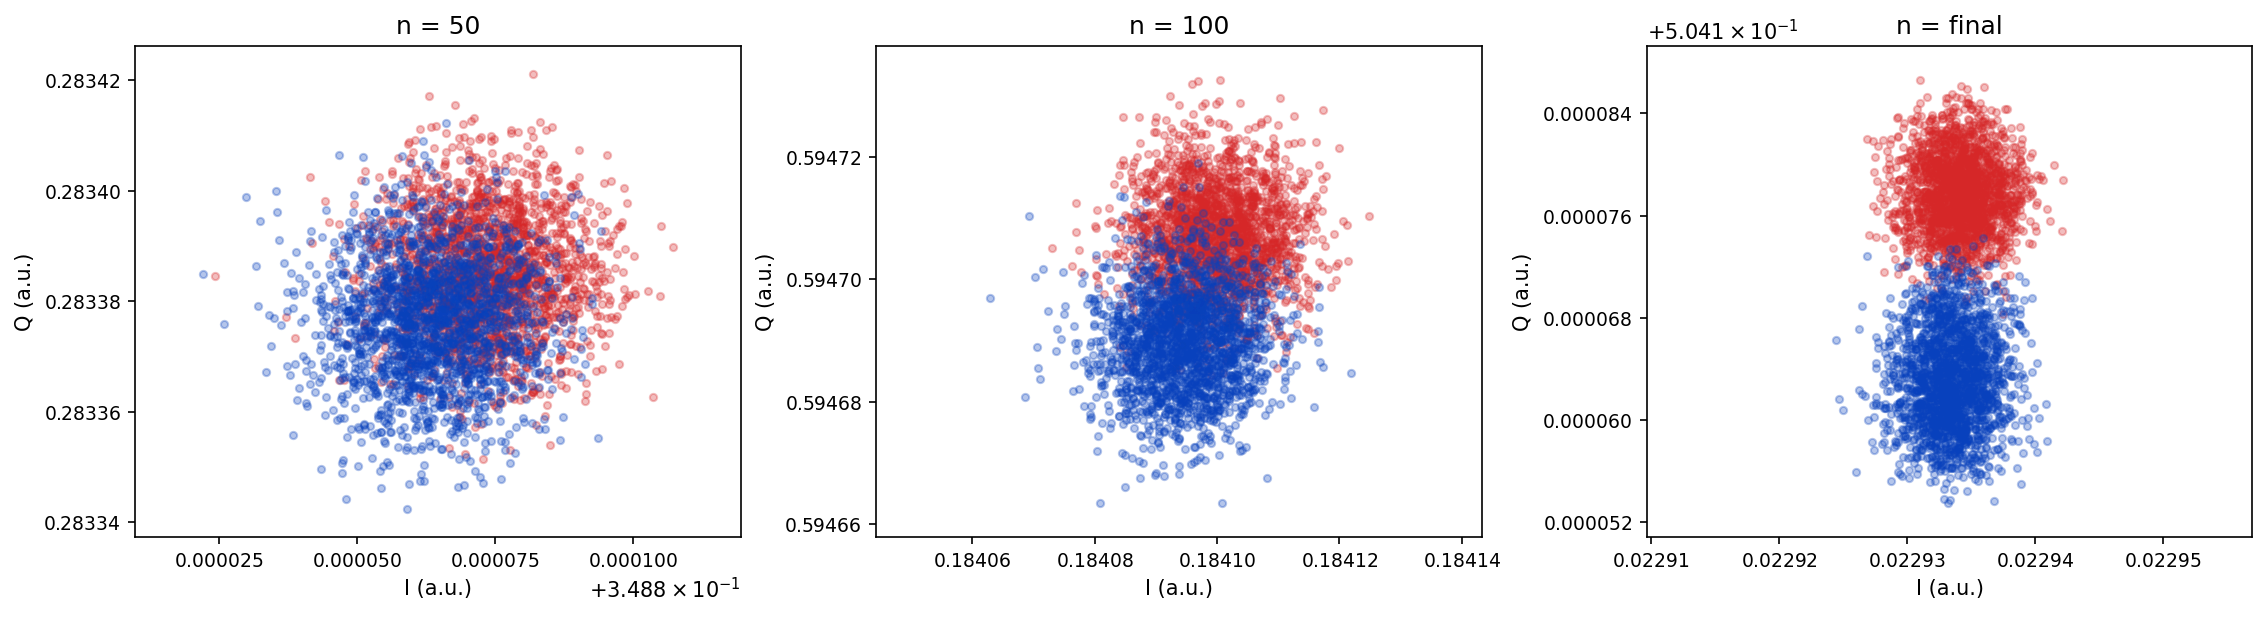

In [67]:
# Indices to show (100th, 500th, final)
idx_list = [50, 100, -1]
idx_names = ["n = 50", "n = 100", "n = final"]

# Safety in case your traces are shorter than 501 samples
T = results['sensor_results'][0]['I'].shape[-1]
idx_list = [i if i == -1 or i < T else -1 for i in idx_list]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=150, constrained_layout=True)

for ax, idx, name in zip(axes, idx_list, idx_names):
    xs, ys = [], []
    for state_indx in range(len(charge_states)):
        I = results['sensor_results'][0]['I'][state_indx]  # (n_realizations, n_time)
        Q = results['sensor_results'][0]['Q'][state_indx]

        I_integrated = np.cumsum(I, axis=-1) / np.arange(1, I.shape[1] + 1)
        Q_integrated = np.cumsum(Q, axis=-1) / np.arange(1, Q.shape[1] + 1)

        x = I_integrated[:, idx]
        y = Q_integrated[:, idx]
        xs.append(x); ys.append(y)

        ax.scatter(x, y, s=12, label=f'state {state_indx}',
                   color=colors[state_indx], alpha=0.3)

    ax.set_title(f"{name}", pad=6)
    ax.set_xlabel('I (a.u.)')
    ax.set_ylabel('Q (a.u.)')
    ax.axis('equal')

    # Pretty ticks (plain numbers, ~5 ticks)
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='plain', axis='both')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.tick_params(axis='both', which='major', labelsize=9)

    # Pad limits a bit around data
    X = np.concatenate(xs); Y = np.concatenate(ys)
    xr = X.max() - X.min(); yr = Y.max() - Y.min()
    pad_x = 0.08 * (xr if xr > 0 else (abs(X.mean()) + 1e-12))
    pad_y = 0.08 * (yr if yr > 0 else (abs(Y.mean()) + 1e-12))
    ax.set_xlim(X.min() - pad_x, X.max() + pad_x)
    ax.set_ylim(Y.min() - pad_y, Y.max() + pad_y)

# Single legend for the whole figure (use handles from last axes)
handles, labels_ = axes[-1].get_legend_handles_labels()
# fig.legend(handles, labels_, loc="upper center", ncol=len(labels_), frameon=True)

plt.show()


C:\Users\rouvenkoch\AppData\Local\Temp\ipykernel_65516\3969258907.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


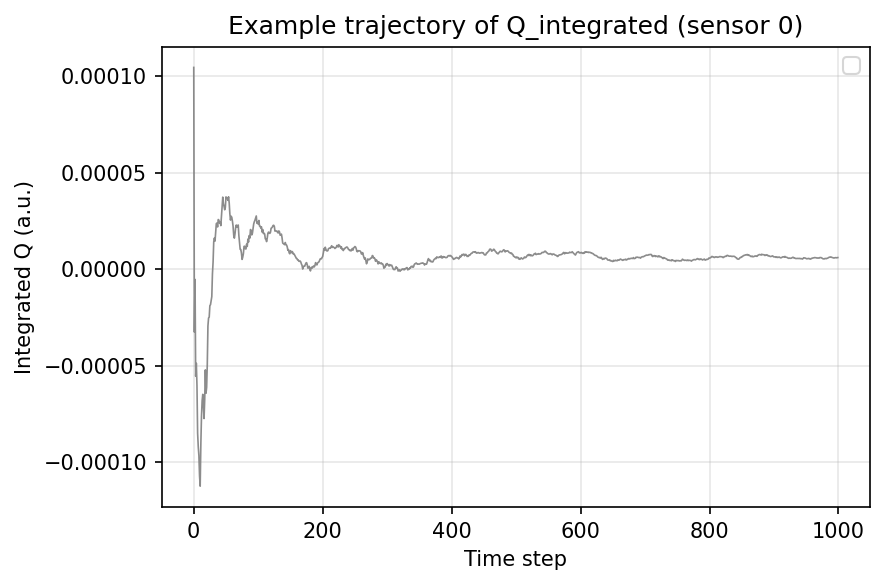

In [73]:
import matplotlib.pyplot as plt
import numpy as np


index = 3  # example trajectory index
t = np.arange(1000) # or use your 'times' array

plt.figure(dpi=150, figsize=(6,4))
for i in range(1):
    plt.plot(t, Q_integrated_all_s0[i,:] - Q_integrated_all_s0[i+2,:], color="gray", alpha=0.9, lw=0.8)
plt.xlabel("Time step")
plt.ylabel("Integrated Q (a.u.)")
plt.title("Example trajectory of Q_integrated (sensor 0)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


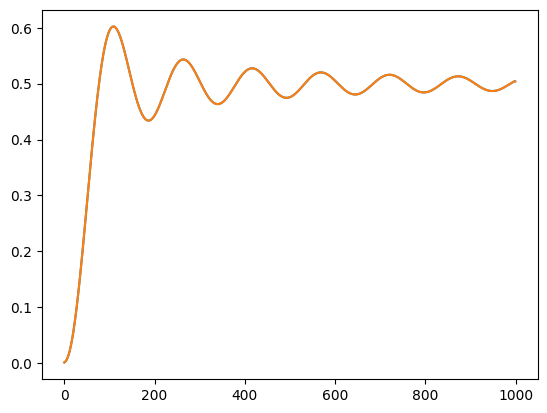

In [72]:
I = results['sensor_results'][0]['I'][0]
Q = results['sensor_results'][0]['Q'][0]
I_integrated = np.cumsum(I, axis=-1)  / np.arange(1, len(I[0]) + 1)
Q_integrated = np.cumsum(Q, axis=-1)  / np.arange(1, len(Q[0]) + 1)

x = Q_integrated[0,:]
y = Q_integrated[100,:]

plt.plot(x)
plt.plot(y)
plt.show()


Analyzing correlation effects...
Actual correlation coefficient: 0.9334
Target correlation coefficient: 0.7000


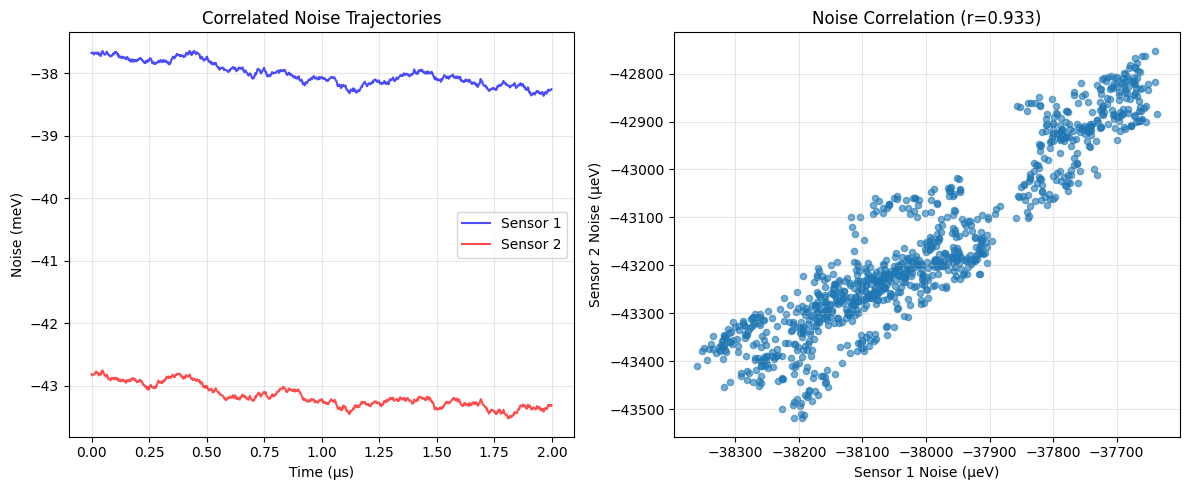


Example completed successfully!
The correlated noise implementation allows you to:
- Set correlation strength between sensors
- Use any base noise model (OU_noise, OverFNoise)
- Maintain JAX compatibility for efficient computation


In [13]:
# Analyze the correlation
print("\nAnalyzing correlation effects...")

# Extract noise trajectories for first realization
sensor1_noise = results['sensor_results'][0]['noise_trajectory'][0, 0]  # First state, first realization
sensor2_noise = results['sensor_results'][1]['noise_trajectory'][0, 0]

# Calculate actual correlation coefficient
correlation_coeff = np.corrcoef(sensor1_noise, sensor2_noise)[0, 1]
print(f"Actual correlation coefficient: {correlation_coeff:.4f}")
print(f"Target correlation coefficient: {correlation_matrix[0, 1]:.4f}")

# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot noise trajectories
ax1.plot(times*1e6, sensor1_noise*1e3, 'b-', label='Sensor 1', alpha=0.7)
ax1.plot(times*1e6, sensor2_noise*1e3, 'r-', label='Sensor 2', alpha=0.7)
ax1.set_xlabel('Time (μs)')
ax1.set_ylabel('Noise (meV)')
ax1.set_title('Correlated Noise Trajectories')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot correlation scatter
ax2.scatter(sensor1_noise*1e6, sensor2_noise*1e6, alpha=0.6, s=20)
ax2.set_xlabel('Sensor 1 Noise (μeV)')
ax2.set_ylabel('Sensor 2 Noise (μeV)')
ax2.set_title(f'Noise Correlation (r={correlation_coeff:.3f})')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nExample completed successfully!")
print("The correlated noise implementation allows you to:")
print("- Set correlation strength between sensors")
print("- Use any base noise model (OU_noise, OverFNoise)")
print("- Maintain JAX compatibility for efficient computation")

In [23]:
# Plotting functions

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


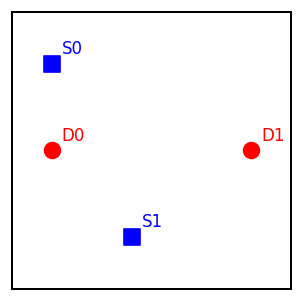

In [24]:
# Example positions (like from user's optimizer memory)
dot_positions = np.array([[0, 0], [100, 0]])
sensor_positions = np.array([[0, 43.3], [40, -43.3]])

ax = hf.plot_qubit_array(dot_positions, sensor_positions)
plt.show()
